<a href="https://colab.research.google.com/github/FaiazS/LoRA_Housing_Price_Prediction/blob/main/Low_Rank_Adaptation(LoRA)_PEFT_Technique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How this Works:

The Original Weights of the Pre-Trained Model is Frozen(Not updated during Fine-Tuning)

A and B, 2 Low - Ranked Matrices are trained to capture the

Use-Case / Task-Specific Knowledge that we are Fine-Tuning the Model for.

The LoRA update A and B adapts the Model with fewer parameters keeping both precision(accuracy) and computation(space) as the trade offs and compromising one for another based on the end goal we are trying to acheive depending the Use-Case/Task we are training the Model for.



In [13]:
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import models, layers

In [8]:
class LoRALayer(tf.keras.layers.Layer):

  def __init__(self, input_dim, output_dim, rank = 2, alpha = 1.0):

    super(LoRALayer, self).__init__()

    self.rank = rank

    self.alpha = alpha  #Scaling Factor

    #The Frozen Original Weight Matrix

    self.original_weight = self.add_weight(shape =(input_dim, output_dim), initializer = "random_normal", trainable = False)

    #Low-Rank Matrices A and B

    self.A = self.add_weight(shape = (input_dim, rank), initializer = "random_normal", trainable = True)

    self.B = self.add_weight(shape =(rank, output_dim), initializer = "random_normal", trainable = True)




  def call(self, inputs):

    lora_update = tf.matmul(inputs, self.A)

    lora_update = tf.matmul(lora_update, self.B) * self.alpha

    return tf.matmul(inputs, self.original_weight) + lora_update  # The Original Pre - Trained Model Weight is Frozen, only the Low Rank Matrices A and B are updated.


Building a Regression Model witg LoRa

In [9]:
#Loading the dataset

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.california_housing.load_data()

x_train = x_train.astype('float32')

x_test = x_test.astype('float32')

In [16]:
#Defining the Model with LoRa

input_dim = x_train.shape[1]

output_dim = 1 #Predicting House Price

inputs = tf.keras.Input(shape = (input_dim,))

x = LoRALayer(input_dim, 16, rank = 2, alpha = 1.0)(inputs)

x = layers.ReLU()(x)

x = layers.Dense(1)(x)  #Final regression output.

regression_model = tf.keras.Model(inputs, x)


#Compiling the Model

regression_model.compile(tf.keras.optimizers.Adam(learning_rate = 0.01), loss = "mse")

#Training the model

history = regression_model.fit( x_train, y_train, epochs = 100, validation_data =(x_test, y_test), batch_size = 32,verbose = 1)

Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37716303872.0000 - val_loss: 24085051392.0000
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23210305536.0000 - val_loss: 15688427520.0000
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13823205376.0000 - val_loss: 11486839808.0000
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10963198976.0000 - val_loss: 11460811776.0000
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11150930944.0000 - val_loss: 11334789120.0000
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10840603648.0000 - val_loss: 11019225088.0000
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10681631744.0000 - val_loss: 10973874176.0000
Epoch 8/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 10819828736.0000 - val_loss: 10622724096.0000
Epoch 9/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10480802816.0000 - val_loss: 10706487296.0000
Epoch 10/100
516/516 ━━━━━━━━━━━━━━━━

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6068533248.0000
Testing Loss/Error 5687320576.0


<ipython-input-17-54080605cf04>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


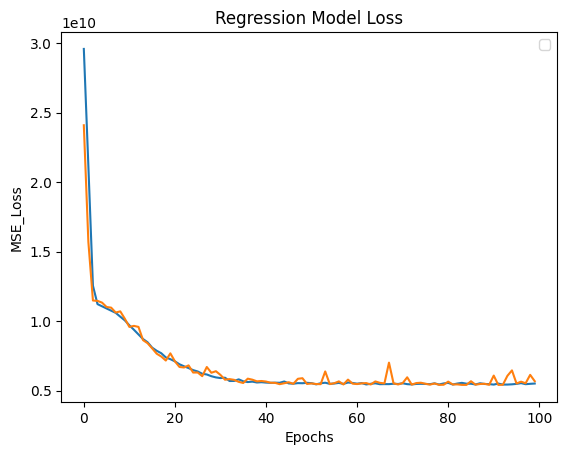

In [17]:
#Evaluating and Visualizing Model Performance

test_loss = regression_model.evaluate(x_test, y_test)

print("Testing Loss/Error" , test_loss)

#Plotting the training loss

plt.plot(history.history["loss"])

plt.plot(history.history["val_loss"])

plt.title('Regression Model Loss')

plt.ylabel("MSE_Loss")

plt.xlabel("Epochs")

plt.legend()

plt.show()